In this notebook, we will implement a Noise Conditional Score Network, from the paper [Generative Modeling by Estimating Gradients of the Data Distribution](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html) by Yang Song and team.

Noise Conditional Score Networks (NCSN) are a type of generative model based on estimating and sampling from the Stein score of the logarithmic data density. NCSNs also improve score-based generative modeling by 1) perturbing the data using various levels of noise; and 2) simultaneously estimating scores corresponding to all noise levels by training a single conditional score network. 

Score-based diffusion models use score matching, with which we can train a score network $s_\theta$ to estimate $\nabla_x \log{p}_{data}(x)$, without training a model to estimate $p_{data}(x)$ first.

## Load Libraries

In [40]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from functools import partial
import logging
import os

import numpy as np
import matplotlib.pyplot as plt
import datasets
from rich import print, inspect
from tqdm.notebook import *

import matplotlib.pyplot as plt
%matplotlib inline

## Learning NCSNs via score matching

For a given $\sigma$, the denoising score matching objective is: $$ \ell(\theta;\sigma) \triangleq \frac{1}{2}  \mathbb{E}_{p_{data}(x)}\mathbb{E}_{\tilde{x}\sim\mathcal{N}(x, \sigma^2I)} \ell\left [\left \|  s_\theta(\tilde{x}, \sigma)+\frac{(\tilde{x}-x)}{\sigma^2}\right \|_2^2  \right ]$$

And for all $σ$: $$\sigma \in \left \{\sigma_{i}  \right \}_{i=1}^L \triangleq \frac{1}{L} \sum_{i=1}^L λ(σ_i) ℓ(θ; σ_i)$$
The paper's authors found that when score networks are trained to optimality, $\left \|  s_\theta(x, \sigma)\right \|_{2} \propto \frac{1}{\sigma}$. This observation led them to choose $ λ(σ) = σ^2 $. 

From this, our training objective becomes:
$$ λ(σ)\ell(\theta;\sigma) = \frac{1}{2} \mathbb{E}\left [ \left \| \sigma s_\theta(\tilde{x}, σ) + \frac{\tilde{x} - x}{\sigma} \right \|_2^2 \right ]$$ 

In [23]:
def anneal_dsm_score_estimation(scorenet, samples, labels, sigmas, anneal_power=2.):
  used_sigmas = sigmas[labels].view(samples.shape[0], *([1] * len(samples.shape[1:])))
  perturbed_samples = samples + torch.randn_like(samples) * used_sigmas
  target = - 1 / (used_sigmas ** 2) * (perturbed_samples - samples)
  scores = scorenet(perturbed_samples, labels)
  target = target.view(target.shape[0], -1)
  scores = scores.view(scores.shape[0], -1)
  loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1) * used_sigmas.squeeze() ** anneal_power
  return loss.mean(dim=0)

## Model Components

### Instance Normalization

Conditional instance normalization, first proposed by [Dumoulin et al.](https://arxiv.org/abs/1610.07629v5), enables the Noise Conditional Score Network $s_\theta(x, σ)$ to take account of $σ$ when predicting the scores.It essentially preserves the data distributions "place" around the mean. It is formulated as $$ z_{k} = γ[i,k]\frac{x_k - \mu_k}{s_k}+\beta[i,k]$$

By adding a fraction of $\mu_k$ to the normalized distribution, some of the content removed from the feature maps (due to subtracting the mean from the k-th feature map) is returned to the distribution for representation by the score network $s_\theta(x,σ)$

$$ z_{k} = γ[i,k]\frac{x_k - \mu_k}{s_k}+\beta[i,k]+α[i,k]\frac{m_k - m}{v}$$

In [3]:
class CondInstanceNormPlus(nn.Module):
  def __init__(self, num_features, num_classes, bias=True):
    super().__init__()
    self.num_features = num_features
    self.bias = bias
    self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
    if bias:
      self.embed = nn.Embedding(num_classes, num_features * 3)
      self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02) # initialize scale at N(1, 0.02)
      self.embed.weight.data[:, 2 * num_features:].zero_() # initialize bias at 0
    else:
      self.embed = nn.Embedding(num_classes, 2 * num_features)
      self.embed.weight.data.normal_(1, 0.02)
    
  def forward(self, x, y):
    means = torch.mean(x, dim=(2, 3))
    m = torch.mean(means, dim=-1, keepdim=True)
    v = torch.var(means, dim=-1, keepdim=True)
    means = (means - m) / (torch.sqrt(v + 1e-5))
    h = self.instance_norm(x)

    if self.bias:
      gamma, alpha, beta = self.embed(y).chunk(3, dim=-1)
      h = h + means[..., None, None] * alpha[..., None, None]
      out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
    else:
      gamma, alpha = self.embed(y).chunk(2, dim=-1)
      h = h + means[..., None, None] * alpha[..., None, None]
      out = gamma.view(-1, self.num_features, 1, 1) * h
    return out

### Dilated Convolutions
Dilated convolutions are used to increase the size of the receptive field while maintaining the resolution of feature maps.

In [30]:
def conv3x3(in_planes, out_planes, stride=1, bias=False):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=bias)


def conv1x1(in_planes, out_planes, stride=1, bias=False):
    "1x1 convolution"
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                     padding=0, bias=bias)


def dilated_conv3x3(in_planes, out_planes, dilation, bias=True):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=dilation, dilation=dilation, bias=bias)


class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        if self.bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.bn(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=1)
            out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * out
        return out


class ConditionalInstanceNorm2d(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 2)
            self.embed.weight.data[:, :num_features].uniform_()  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, num_features)
            self.embed.weight.data.uniform_()

    def forward(self, x, y):
        h = self.instance_norm(x)
        if self.bias:
            gamma, beta = self.embed(y).chunk(2, dim=-1)
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma = self.embed(y)
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out


class CRPBlock(nn.Module):
    def __init__(self, features, n_stages, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        for i in range(n_stages):
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.MaxPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x


class CondCRPBlock(nn.Module):
    def __init__(self, features, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        for i in range(n_stages):
            self.norms.append(normalizer(features, num_classes, bias=True))
            self.convs.append(conv3x3(features, features, stride=1, bias=False))
        self.n_stages = n_stages
        self.maxpool = nn.AvgPool2d(kernel_size=5, stride=1, padding=2)
        self.act = act

    def forward(self, x, y):
        x = self.act(x)
        path = x
        for i in range(self.n_stages):
            path = self.norms[i](path, y)
            path = self.maxpool(path)
            path = self.convs[i](path)
            x = path + x
        return x


class CondRCUBlock(nn.Module):
    def __init__(self, features, n_blocks, n_stages, num_classes, normalizer, act=nn.ReLU()):
        super().__init__()

        for i in range(n_blocks):
            for j in range(n_stages):
                setattr(self, '{}_{}_norm'.format(i + 1, j + 1), normalizer(features, num_classes, bias=True))
                setattr(self, '{}_{}_conv'.format(i + 1, j + 1),
                        conv3x3(features, features, stride=1, bias=False))

        self.stride = 1
        self.n_blocks = n_blocks
        self.n_stages = n_stages
        self.act = act

    def forward(self, x, y):
        for i in range(self.n_blocks):
            residual = x
            for j in range(self.n_stages):
                x = getattr(self, '{}_{}_norm'.format(i + 1, j + 1))(x, y)
                x = self.act(x)
                x = getattr(self, '{}_{}_conv'.format(i + 1, j + 1))(x)
            x += residual
        return x


class CondMSFBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer):
        """
        :param in_planes: tuples of input planes
        """
        super().__init__()
        assert isinstance(in_planes, list) or isinstance(in_planes, tuple)

        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.features = features

        for i in range(len(in_planes)):
            self.convs.append(conv3x3(in_planes[i], features, stride=1, bias=True))
            self.norms.append(normalizer(in_planes[i], num_classes, bias=True))

    def forward(self, xs, y, shape):
        sums = torch.zeros(xs[0].shape[0], self.features, *shape, device=xs[0].device)
        for i in range(len(self.convs)):
            h = self.norms[i](xs[i], y)
            h = self.convs[i](h)
            h = F.interpolate(h, size=shape, mode='bilinear', align_corners=True)
            sums += h
        return sums


class CondRefineBlock(nn.Module):
    def __init__(self, in_planes, features, num_classes, normalizer, act=nn.ReLU(), start=False, end=False):
        super().__init__()

        assert isinstance(in_planes, tuple) or isinstance(in_planes, list)
        self.n_blocks = n_blocks = len(in_planes)

        self.adapt_convs = nn.ModuleList()
        for i in range(n_blocks):
            self.adapt_convs.append(
                CondRCUBlock(in_planes[i], 2, 2, num_classes, normalizer, act)
            )

        self.output_convs = CondRCUBlock(features, 3 if end else 1, 2, num_classes, normalizer, act)

        if not start:
            self.msf = CondMSFBlock(in_planes, features, num_classes, normalizer)

        self.crp = CondCRPBlock(features, 2, num_classes, normalizer, act)

    def forward(self, xs, y, output_shape):
        assert isinstance(xs, tuple) or isinstance(xs, list)
        hs = []
        for i in range(len(xs)):
            h = self.adapt_convs[i](xs[i], y)
            hs.append(h)

        if self.n_blocks > 1:
            h = self.msf(hs, y, output_shape)
        else:
            h = hs[0]

        h = self.crp(h, y)
        h = self.output_convs(h, y)

        return h


class ConvMeanPool(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True, adjust_padding=False):
        super().__init__()
        if not adjust_padding:
            self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        else:
            self.conv = nn.Sequential(
                nn.ZeroPad2d((1, 0, 1, 0)),
                nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
            )

    def forward(self, inputs):
        output = self.conv(inputs)
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return output


class MeanPoolConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)

    def forward(self, inputs):
        output = inputs
        output = sum(
            [output[:, :, ::2, ::2], output[:, :, 1::2, ::2], output[:, :, ::2, 1::2], output[:, :, 1::2, 1::2]]) / 4.
        return self.conv(output)


class UpsampleConv(nn.Module):
    def __init__(self, input_dim, output_dim, kernel_size=3, biases=True):
        super().__init__()
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride=1, padding=kernel_size // 2, bias=biases)
        self.pixelshuffle = nn.PixelShuffle(upscale_factor=2)

    def forward(self, inputs):
        output = inputs
        output = torch.cat([output, output, output, output], dim=1)
        output = self.pixelshuffle(output)
        return self.conv(output)


class ConditionalResidualBlock(nn.Module):
    def __init__(self, input_dim, output_dim, num_classes, resample=None, act=nn.ELU(),
                 normalization=ConditionalBatchNorm2d, adjust_padding=False, dilation=None):
        super().__init__()
        self.non_linearity = act
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.resample = resample
        if resample == 'down':
            if dilation is not None:
                self.conv1 = dilated_conv3x3(input_dim, input_dim, dilation=dilation)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
            else:
                self.conv1 = nn.Conv2d(input_dim, input_dim, 3, stride=1, padding=1)
                self.normalize2 = normalization(input_dim, num_classes)
                self.conv2 = ConvMeanPool(input_dim, output_dim, 3, adjust_padding=adjust_padding)
                conv_shortcut = partial(ConvMeanPool, kernel_size=1, adjust_padding=adjust_padding)

        elif resample is None:
            if dilation is not None:
                conv_shortcut = partial(dilated_conv3x3, dilation=dilation)
                self.conv1 = dilated_conv3x3(input_dim, output_dim, dilation=dilation)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = dilated_conv3x3(output_dim, output_dim, dilation=dilation)
            else:
                conv_shortcut = nn.Conv2d
                self.conv1 = nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=1, padding=1)
                self.normalize2 = normalization(output_dim, num_classes)
                self.conv2 = nn.Conv2d(output_dim, output_dim, kernel_size=3, stride=1, padding=1)
        else:
            raise Exception('invalid resample value')

        if output_dim != input_dim or resample is not None:
            self.shortcut = conv_shortcut(input_dim, output_dim)

        self.normalize1 = normalization(input_dim, num_classes)

    def forward(self, x, y):
        output = self.normalize1(x, y)
        output = self.non_linearity(output)
        output = self.conv1(output)
        output = self.normalize2(output, y)
        output = self.non_linearity(output)
        output = self.conv2(output)

        if self.output_dim == self.input_dim and self.resample is None:
            shortcut = x
        else:
            shortcut = self.shortcut(x)

        return shortcut + output


class ConditionalInstanceNorm2dPlus(nn.Module):
    def __init__(self, num_features, num_classes, bias=True):
        super().__init__()
        self.num_features = num_features
        self.bias = bias
        self.instance_norm = nn.InstanceNorm2d(num_features, affine=False, track_running_stats=False)
        self.logit_transform = True
        
        if bias:
            self.embed = nn.Embedding(num_classes, num_features * 3)
            self.embed.weight.data[:, :2 * num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
            self.embed.weight.data[:, 2 * num_features:].zero_()  # Initialise bias at 0
        else:
            self.embed = nn.Embedding(num_classes, 2 * num_features)
            self.embed.weight.data.normal_(1, 0.02)

    def forward(self, x, y):
        means = torch.mean(x, dim=(2, 3))
        m = torch.mean(means, dim=-1, keepdim=True)
        v = torch.var(means, dim=-1, keepdim=True)
        means = (means - m) / (torch.sqrt(v + 1e-5))
        h = self.instance_norm(x)

        if self.bias:
            gamma, alpha, beta = self.embed(y).chunk(3, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h + beta.view(-1, self.num_features, 1, 1)
        else:
            gamma, alpha = self.embed(y).chunk(2, dim=-1)
            h = h + means[..., None, None] * alpha[..., None, None]
            out = gamma.view(-1, self.num_features, 1, 1) * h
        return out

### U-Net

In [31]:
class CondRefineNetDilated(nn.Module):
    def __init__(self,):
        super().__init__()
        self.logit_transform = False
        # self.norm = ConditionalInstanceNorm2d
        self.norm = ConditionalInstanceNorm2dPlus
        self.ngf = ngf = 64
        self.num_classes = 50
        self.image_size = 32
        self.act = act = nn.ELU()
        self.data_channels = 3
        # self.act = act = nn.ReLU(True)

        self.begin_conv = nn.Conv2d(self.data_channels, ngf, 3, stride=1, padding=1)
        self.normalizer = self.norm(ngf, self.num_classes)

        self.end_conv = nn.Conv2d(ngf, self.data_channels, 3, stride=1, padding=1)

        self.res1 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(self.ngf, self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res2 = nn.ModuleList([
            ConditionalResidualBlock(self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm)]
        )

        self.res3 = nn.ModuleList([
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                     normalization=self.norm, dilation=2),
            ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                     normalization=self.norm, dilation=2)]
        )

        if self.image_size == 28:
            self.res4 = nn.ModuleList([
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                         normalization=self.norm, adjust_padding=True, dilation=4),
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                         normalization=self.norm, dilation=4)]
            )
        else:
            self.res4 = nn.ModuleList([
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample='down', act=act,
                                         normalization=self.norm, adjust_padding=False, dilation=4),
                ConditionalResidualBlock(2 * self.ngf, 2 * self.ngf, self.num_classes, resample=None, act=act,
                                         normalization=self.norm, dilation=4)]
            )

        self.refine1 = CondRefineBlock([2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act, start=True)
        self.refine2 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], 2 * self.ngf, self.num_classes, self.norm, act=act)
        self.refine3 = CondRefineBlock([2 * self.ngf, 2 * self.ngf], self.ngf, self.num_classes, self.norm, act=act)
        self.refine4 = CondRefineBlock([self.ngf, self.ngf], self.ngf, self.num_classes, self.norm, act=act, end=True)

    def _compute_cond_module(self, module, x, y):
        for m in module:
            x = m(x, y)
        return x

    def forward(self, x, y):
        if not self.logit_transform:
            x = 2 * x - 1.

        output = self.begin_conv(x)

        layer1 = self._compute_cond_module(self.res1, output, y)
        layer2 = self._compute_cond_module(self.res2, layer1, y)
        layer3 = self._compute_cond_module(self.res3, layer2, y)
        layer4 = self._compute_cond_module(self.res4, layer3, y)

        ref1 = self.refine1([layer4], y, layer4.shape[2:])
        ref2 = self.refine2([layer3, ref1], y, layer3.shape[2:])
        ref3 = self.refine3([layer2, ref2], y, layer2.shape[2:])
        output = self.refine4([layer1, ref3], y, layer1.shape[2:])

        output = self.normalizer(output, y)
        output = self.act(output)
        output = self.end_conv(output)
        return output

## Prepare Data

Using custom data configuration huggan--CelebA-faces-8a807f0d7d4912ca
Found cached dataset parquet (C:/Users/Hedronstone/.cache/huggingface/datasets/huggan___parquet/huggan--CelebA-faces-8a807f0d7d4912ca/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Example images from CelebA-faces

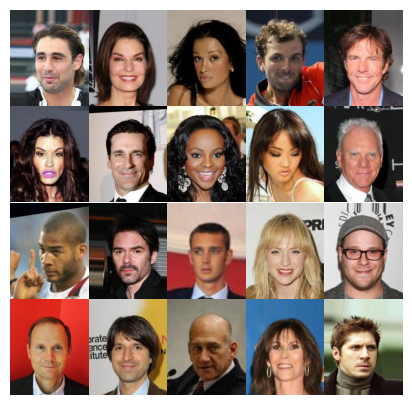

In [32]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from datasets import load_dataset

dataset_name = "huggan/CelebA-faces"
dataset = load_dataset(dataset_name, split="train")

image_size = 32

# forward transform
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) -1),
])

def image_grid(data, title="CelebA-faces"):
    "For displaying images from CelebA dataset"
    fig = plt.figure(figsize=(10,5))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 5),
                 axes_pad=0, share_all=True)
    
    for ax, im in zip(grid, data[:25]['image']):
        ax.imshow(im)
        ax.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    print(f"[bold magenta]Example images from {title}[/bold magenta]")
    plt.show()

image_grid(dataset)

## Train Score Network

In [35]:
# move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score_network = CondRefineNetDilated()
score_network = score_network.to(device)

# =========== housekeeping =============

def transforms(examples):
    examples['image'] = [transform(image) for image in examples['image']]
    return examples

transformed_dataset = dataset.with_transform(transforms)

# to accelerate training computations
torch.backends.cudnn.benchmark = True

# ======================================

# training epochs
n_epochs = 2

# train batch size
batch_size = 64

# stage data
dataloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# for reproducibility
g = torch.Generator(device=device).manual_seed(3141)

# optimizer
optimizer = torch.optim.Adam(score_network.parameters(), lr=2e-5)

# sigma schedule
sigma_begin = 1.
sigma_end = 0.01
num_classes = 50

sigmas = torch.tensor(
    np.exp(np.linspace(np.log(sigma_begin), np.log(sigma_end), num_classes))
    ).float().to(device)

# for recordkeeping
step = 0

In [36]:
# train loop
for epoch in range(n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        X = batch['image']
        
        step += 1
        
        score_network.train()
        X = X.to(device)
        X = X / 256. * 255 + torch.rand_like(X) / 256.
        
        labels = torch.randint(0, len(sigmas), (X.shape[0],), device=X.device)
        
        loss = anneal_dsm_score_estimation(score_network, X, labels, sigmas)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 100 == 0:
            print("step: {}, loss: {}".format(step, loss.item()))

  0%|          | 0/3166 [00:00<?, ?it/s]

step: 100, loss: 1155.7353515625

step: 200, loss: 970.0010986328125

step: 300, loss: 992.41015625

step: 400, loss: 1033.103515625

step: 500, loss: 839.3780517578125

step: 600, loss: 941.350341796875

step: 700, loss: 911.7418212890625

step: 800, loss: 843.66943359375

step: 900, loss: 908.3616943359375

step: 1000, loss: 867.9192504882812

step: 1100, loss: 786.127197265625

step: 1200, loss: 754.324462890625

step: 1300, loss: 857.7462768554688

step: 1400, loss: 869.2724609375

step: 1500, loss: 834.542236328125

step: 1600, loss: 826.75634765625

step: 1700, loss: 781.788818359375

step: 1800, loss: 894.368408203125

step: 1900, loss: 770.5060424804688

step: 2000, loss: 632.967529296875

step: 2100, loss: 636.2088623046875

step: 2200, loss: 623.1064453125

step: 2300, loss: 758.7020263671875

step: 2400, loss: 743.0060424804688

step: 2500, loss: 674.03173828125

step: 2600, loss: 702.74658203125

step: 2700, loss: 619.978515625

step: 2800, loss: 751.18701171875

step: 2900, loss: 657.1307983398438

step: 3000, loss: 658.8389282226562

step: 3100, loss: 698.6373901367188

  0%|          | 0/3166 [00:00<?, ?it/s]

step: 3200, loss: 685.1572265625

step: 3300, loss: 678.2614135742188

step: 3400, loss: 780.966552734375

step: 3500, loss: 660.9530029296875

step: 3600, loss: 638.719482421875

step: 3700, loss: 658.870849609375

step: 3800, loss: 630.6234741210938

step: 3900, loss: 639.1399536132812

step: 4000, loss: 675.1710815429688

step: 4100, loss: 666.7010498046875

step: 4200, loss: 579.3523559570312

step: 4300, loss: 629.6868896484375

step: 4400, loss: 586.2540283203125

step: 4500, loss: 620.0919189453125

step: 4600, loss: 637.4888916015625

step: 4700, loss: 601.8184204101562

step: 4800, loss: 606.4961547851562

step: 4900, loss: 648.0374755859375

step: 5000, loss: 608.1292724609375

step: 5100, loss: 529.1690063476562

step: 5200, loss: 591.2406616210938

step: 5300, loss: 536.108642578125

step: 5400, loss: 508.3516540527344

step: 5500, loss: 529.8460083007812

step: 5600, loss: 527.9368896484375

step: 5700, loss: 552.5179443359375

step: 5800, loss: 494.84942626953125

step: 5900, loss: 553.118896484375

step: 6000, loss: 453.25921630859375

step: 6100, loss: 593.3445434570312

step: 6200, loss: 542.34912109375

step: 6300, loss: 617.8447265625

In [38]:
# save model
path = 'ncsn.pt'
torch.save({
    'epoch': step,
    'model_state_dict': score_network,
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, path)

## Sampling Loop

In [62]:
@torch.no_grad()
def anneal_langevin_dynamics(x_mod, score_network, sigmas, n_steps_each=100, step_lr=0.00002):
    images = []
    
    for c, sigma in tqdm(enumerate(sigmas), desc='annealed Langevin dynamics sampling'):
        labels = torch.ones(x_mod.shape[0], device=x_mod.device) * c
        labels = labels.long()
        step_size = step_lr * (sigma / sigmas[-1]) ** 2
        step_size = step_size.to('cpu')
        for s in range(n_steps_each):
            images.append(torch.clamp(x_mod, 0.0, 1.0).to('cpu'))
            noise = torch.randn_like(x_mod) * np.sqrt(step_size * 2)
            grad = score_network(x_mod, labels)
            x_mod = x_mod + step_size * grad + noise
        
        return images

In [63]:
score_network.eval()
grid_size = 5

imgs = []

samples = torch.rand(grid_size ** 2, 3, 32, 32, device=device)
all_samples = anneal_langevin_dynamics(samples, score_network, sigmas)

annealed Langevin dynamics sampling: 0it [00:00, ?it/s]